# 1. Initial Setup and Configuration
This section sets up all the necessary libraries, defines file paths, and specifies the key parameters for your training process. You can easily adjust these settings to fit your needs.

In [3]:
# %pip install pandas
# import pandas as pd
# import shutil
# import os

# def sort_images_by_class(dataset_path, csv_path):
#     """
#     Sorts images from a dataset into subfolders based on a classification CSV.

#     Args:
#         dataset_path (str): The path to the directory containing the images.
#         csv_path (str): The path to the CSV file with image classifications.
#     """
#     class_map = {
#         0: "No Disease",
#         1: "Bacterial Pneumonia",
#         2: "Viral Pneumonia"
#     }

#     if not os.path.exists(dataset_path):
#         print(f"Error: Dataset path '{dataset_path}' does not exist.")
#         return

#     if not os.path.exists(csv_path):
#         print(f"Error: CSV path '{csv_path}' does not exist.")
#         return

#     try:
#         df = pd.read_csv(csv_path)
#     except Exception as e:
#         print(f"Error reading CSV file: {e}")
#         return

#     # Create destination directories
#     for class_name in class_map.values():
#         dir_path = os.path.join(dataset_path, class_name)
#         os.makedirs(dir_path, exist_ok=True)
#         print(f"Created directory: {dir_path}")

#     # Process each row in the DataFrame
#     for _, row in df.iterrows():
#         file_name = row['file_name']
#         class_id = row['class_id']
        
#         # Construct full file paths
#         source_path = os.path.join(dataset_path, file_name)
        
#         if class_id in class_map:
#             dest_folder = class_map[class_id]
#             dest_path = os.path.join(dataset_path, dest_folder, file_name)
            
#             # Check if source file exists before moving
#             if os.path.exists(source_path):
#                 try:
#                     shutil.move(source_path, dest_path)
#                     print(f"Moved '{file_name}' to '{dest_folder}'")
#                 except Exception as e:
#                     print(f"Could not move '{file_name}': {e}")
#             else:
#                 print(f"Warning: File '{file_name}' not found in '{dataset_path}'")
#         else:
#             print(f"Warning: Class ID '{class_id}' for '{file_name}' is not recognized.")

# if __name__ == "__main__":
#     # Example usage:
#     # Replace 'path/to/your/dataset' and 'path/to/your/annotations.csv' with your actual paths.
#     dataset_folder = "./train_images"
#     csv_file = "./labels_train.csv"
    
#     sort_images_by_class(dataset_folder, csv_file)

In [4]:
%pip install torch
%pip install torchvision
%pip install tqdm
%pip install matplotlib
%pip install scikit-learn
%pip install pillow
%pip install numpy
%pip install onnx
%pip install certifi

  Using cached torch-2.8.0-cp313-cp313-win_amd64.whl.metadata (30 kB)
  Using cached filelock-3.19.1-py3-none-any.whl.metadata (2.1 kB)
  Using cached typing_extensions-4.14.1-py3-none-any.whl.metadata (3.0 kB)
  Using cached sympy-1.14.0-py3-none-any.whl.metadata (12 kB)
  Using cached networkx-3.5-py3-none-any.whl.metadata (6.3 kB)
  Using cached jinja2-3.1.6-py3-none-any.whl.metadata (2.9 kB)
  Using cached fsspec-2025.7.0-py3-none-any.whl.metadata (12 kB)
  Using cached setuptools-80.9.0-py3-none-any.whl.metadata (6.6 kB)
  Using cached mpmath-1.3.0-py3-none-any.whl.metadata (8.6 kB)
  Using cached MarkupSafe-3.0.2-cp313-cp313-win_amd64.whl.metadata (4.1 kB)
Using cached torch-2.8.0-cp313-cp313-win_amd64.whl (241.3 MB)
Using cached sympy-1.14.0-py3-none-any.whl (6.3 MB)
Using cached mpmath-1.3.0-py3-none-any.whl (536 kB)
Using cached typing_extensions-4.14.1-py3-none-any.whl (43 kB)
Using cached filelock-3.19.1-py3-none-any.whl (15 kB)
Using cached fsspec-2025.7.0-py3-none-any.whl 

In [5]:
import ssl
import certifi
import urllib.request

# Set up proper SSL context
ssl_context = ssl.create_default_context(cafile=certifi.where())
urllib.request.install_opener(urllib.request.build_opener(urllib.request.HTTPSHandler(context=ssl_context)))

In [14]:
import os
import json
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models
from torchvision.datasets import ImageFolder
from PIL import Image
import numpy as np
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# ================================
# CONFIGURATION
# ================================

# Set your dataset path here - should contain subdirectories with class names
DATASET_PATH = "./train_images"  # Change this to your dataset path
OUTPUT_DIR = "model_output"
MODEL_NAME = "mobilenet_classifier"

# Training parameters
BATCH_SIZE = 32
NUM_EPOCHS = 10
LEARNING_RATE = 0.001
VALIDATION_SPLIT = 0.2
IMG_SIZE = 224
NUM_WORKERS = 0 # Change to 0 to avoid multiprocessing issues with small datasets

# Create output directory
os.makedirs(OUTPUT_DIR, exist_ok=True)

print(f"Dataset path: {DATASET_PATH}")
print(f"Output directory: {OUTPUT_DIR}")
print(f"Model name: {MODEL_NAME}")
print(f"Number of workers for data loading: {NUM_WORKERS}")

Dataset path: ./train_images
Output directory: model_output
Model name: mobilenet_classifier
Number of workers for data loading: 0


# 2. Data Loading and Preprocessing
This section handles preparing your images for the model. It automatically finds your classes, splits your data into training and validation sets, and applies important transformations like resizing and normalization.

## Explanation of Parameters:

DATASET_PATH: This is the folder where your images are located. It should have subfolders, where each subfolder name is a class name and contains images for that class. For example: animals/dogs/, animals/cats/, etc.

OUTPUT_DIR: The folder where all the generated files (like the trained model and HTML page) will be saved.

MODEL_NAME: The name used for all the output files.

BATCH_SIZE: The number of images processed at once during training. Larger batches can speed up training but require more memory.

NUM_EPOCHS: The number of times the model will see the entire dataset during training. More epochs can lead to better performance but also increase training time and risk of overfitting.

LEARNING_RATE: Controls how much the model's weights are adjusted in response to the estimated error each time the weights are updated. A small number means a more cautious update, and a large number means a more aggressive one.

VALIDATION_SPLIT: The percentage of the dataset to hold back for testing during training. This helps you monitor how well the model is generalizing to new data.

IMG_SIZE: The width and height (in pixels) that all images will be resized to before being fed into the model. MobileNet requires a size of 224x224.

NUM_WORKERS: The number of CPU cores to use for loading data. This can speed up the data loading process.

In [15]:
# ================================
# CHECK GPU AVAILABILITY
# ================================

# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

if device.type == 'cuda':
    print(f"GPU Name: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.2f} GB")

Using device: cpu


In [16]:
# ================================
# DATA LOADING AND PREPROCESSING
# ================================

def find_leaf_classes(root_dir):
    """
    Find all leaf directories (directories with no subdirectories) as classes.
    This handles nested folder structures like animals/dogs/breeds/pug
    """
    leaf_classes = []

    def is_leaf_dir(path):
        """Check if directory contains only files, no subdirectories"""
        if not os.path.isdir(path):
            return False

        contents = os.listdir(path)
        for item in contents:
            item_path = os.path.join(path, item)
            if os.path.isdir(item_path):
                return False

        # Check if it has any image files
        image_extensions = {'.jpg', '.jpeg', '.png', '.bmp', '.gif', '.tiff'}
        has_images = any(os.path.splitext(item)[1].lower() in image_extensions for item in contents)
        return has_images

    # Walk through all directories
    for root, dirs, files in os.walk(root_dir):
        if is_leaf_dir(root):
            # Get relative path and use as class name
            rel_path = os.path.relpath(root, root_dir)
            leaf_classes.append(rel_path.replace(os.sep, '_'))  # Replace separators for class names

    return sorted(leaf_classes)

# Custom Dataset class for handling nested directories
class NestedImageDataset(Dataset):
    def __init__(self, root_dir, classes, transform=None):
        self.root_dir = root_dir
        self.classes = classes
        self.class_to_idx = {cls: idx for idx, cls in enumerate(classes)}
        self.transform = transform
        self.samples = []

        # Build samples list
        for root, dirs, files in os.walk(root_dir):
            # Check if this is a leaf directory
            is_leaf = len([d for d in dirs if os.path.isdir(os.path.join(root, d))]) == 0

            if is_leaf:
                rel_path = os.path.relpath(root, root_dir)
                class_name = rel_path.replace(os.sep, '_')

                if class_name in self.class_to_idx:
                    class_idx = self.class_to_idx[class_name]

                    # Add all image files from this directory
                    image_extensions = {'.jpg', '.jpeg', '.png', '.bmp', '.gif', '.tiff'}
                    for file in files:
                        if os.path.splitext(file)[1].lower() in image_extensions:
                            file_path = os.path.join(root, file)
                            self.samples.append((file_path, class_idx))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, target = self.samples[idx]

        try:
            with Image.open(path) as img:
                img = img.convert('RGB')
                if self.transform:
                    img = self.transform(img)
                return img, target
        except Exception as e:
            print(f"Error loading image {path}: {e}")
            # Return a black image if there's an error
            if self.transform:
                return self.transform(Image.new('RGB', (224, 224))), target
            return Image.new('RGB', (224, 224)), target

# Find classes and create dataset
print("Scanning for classes...")
classes = find_leaf_classes(DATASET_PATH)
print(f"Found {len(classes)} classes: {classes}")

if len(classes) == 0:
    raise ValueError(f"No valid classes found in {DATASET_PATH}. Make sure the directory contains subdirectories with images.")

# Define transforms
train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create full dataset
full_dataset = NestedImageDataset(DATASET_PATH, classes, transform=train_transform)
print(f"Total samples found: {len(full_dataset)}")

if len(full_dataset) == 0:
    raise ValueError("No images found in the dataset. Please check your dataset path and structure.")

# Split dataset into train and validation
train_size = int((1 - VALIDATION_SPLIT) * len(full_dataset))
val_size = len(full_dataset) - train_size

train_dataset, val_dataset = torch.utils.data.random_split(
    full_dataset, [train_size, val_size],
    generator=torch.Generator().manual_seed(42)
)

# Update validation dataset transform
val_dataset.dataset.transform = val_transform

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")

Scanning for classes...
Found 3 classes: ['Bacterial Pneumonia', 'No Disease', 'Viral Pneumonia']
Total samples found: 4672
Training samples: 3737
Validation samples: 935


# 3. Model Definition and Preparation
Here, we load the pre-trained MobileNetV2 model. We keep most of its existing layers (which are great at recognizing general features) but replace the final classification layer with a new one designed to predict your specific classes. This technique is called transfer learning.

## Key Concepts:

Data Augmentation: The train_transform includes techniques like RandomHorizontalFlip and RandomRotation. These artificially create more training data by slightly altering the existing images, which helps the model become more robust and less likely to overfit.

Normalization: The transforms.Normalize step is crucial. It scales the pixel values to a standard range using the mean and standard deviation from the ImageNet dataset, which is what the pre-trained MobileNet model was trained on. This helps the model learn more effectively.

In [17]:
# ================================
# MODEL DEFINITION
# ================================

class MobileNetClassifier(nn.Module):
    def __init__(self, num_classes):
        super(MobileNetClassifier, self).__init__()

        # Load pretrained MobileNet V2
        self.mobilenet = models.mobilenet_v2(pretrained=True)

        # Freeze early layers (optional - you can unfreeze for fine-tuning)
        for param in self.mobilenet.features[:-3].parameters():
            param.requires_grad = False

        # Replace classifier
        self.mobilenet.classifier = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(self.mobilenet.last_channel, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.2),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        return self.mobilenet(x)

# Create model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model = MobileNetClassifier(len(classes))
model.to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, factor=0.5)

print(f"Model created with {len(classes)} output classes")
print(f"Total parameters: {sum(p.numel() for p in model.parameters())}")
print(f"Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")

Using device: cpu
Model created with 3 output classes
Total parameters: 2881283
Trainable parameters: 1863491


# 4. Training and Evaluation
This is where the model learns to classify your images. The code runs for a specified number of epochs, showing you the progress for both the training and validation data. It also saves the best-performing model to a file.

## Optional Optimizations:

Freezing Layers: The code freezes the first few layers of the MobileNet model. This is a common practice in transfer learning, as these layers have already learned to identify basic shapes and colors. Freezing them means we only train the new classification layer, which is much faster. If your dataset is very large and similar to ImageNet, you can unfreeze some of these layers to "fine-tune" them for even better results.

Starting training...

Epoch 1/10
--------------------------------------------------


Validation: 100%|██████████| 30/30 [00:44<00:00,  1.48s/it, Loss=0.4749, Acc=79.57%]


New best model saved! Validation accuracy: 79.57%
Train Loss: 0.5620, Train Acc: 76.88%
Val Loss: 0.4749, Val Acc: 79.57%

Epoch 2/10
--------------------------------------------------


Validation: 100%|██████████| 30/30 [00:40<00:00,  1.35s/it, Loss=0.4748, Acc=79.14%]


Train Loss: 0.4257, Train Acc: 82.26%
Val Loss: 0.4748, Val Acc: 79.14%

Epoch 3/10
--------------------------------------------------


Validation: 100%|██████████| 30/30 [00:39<00:00,  1.32s/it, Loss=0.5651, Acc=79.14%]


Train Loss: 0.3512, Train Acc: 85.52%
Val Loss: 0.5651, Val Acc: 79.14%

Epoch 4/10
--------------------------------------------------


Validation: 100%|██████████| 30/30 [00:41<00:00,  1.39s/it, Loss=0.6023, Acc=79.89%]


New best model saved! Validation accuracy: 79.89%
Train Loss: 0.2989, Train Acc: 87.34%
Val Loss: 0.6023, Val Acc: 79.89%

Epoch 5/10
--------------------------------------------------


Validation: 100%|██████████| 30/30 [00:38<00:00,  1.29s/it, Loss=0.5734, Acc=81.07%]


New best model saved! Validation accuracy: 81.07%
Train Loss: 0.2534, Train Acc: 89.97%
Val Loss: 0.5734, Val Acc: 81.07%

Epoch 6/10
--------------------------------------------------


Validation: 100%|██████████| 30/30 [00:37<00:00,  1.26s/it, Loss=0.6249, Acc=77.86%]


Train Loss: 0.2019, Train Acc: 92.05%
Val Loss: 0.6249, Val Acc: 77.86%

Epoch 7/10
--------------------------------------------------


Validation: 100%|██████████| 30/30 [00:39<00:00,  1.32s/it, Loss=0.7713, Acc=78.72%]


Train Loss: 0.1219, Train Acc: 95.32%
Val Loss: 0.7713, Val Acc: 78.72%

Epoch 8/10
--------------------------------------------------


Validation: 100%|██████████| 30/30 [00:38<00:00,  1.27s/it, Loss=1.0783, Acc=79.04%]


Train Loss: 0.0632, Train Acc: 97.89%
Val Loss: 1.0783, Val Acc: 79.04%

Epoch 9/10
--------------------------------------------------


Validation: 100%|██████████| 30/30 [00:41<00:00,  1.37s/it, Loss=0.9821, Acc=80.43%]


Train Loss: 0.0572, Train Acc: 97.99%
Val Loss: 0.9821, Val Acc: 80.43%

Epoch 10/10
--------------------------------------------------


Validation: 100%|██████████| 30/30 [00:40<00:00,  1.35s/it, Loss=1.0511, Acc=79.47%]


Train Loss: 0.0358, Train Acc: 98.80%
Val Loss: 1.0511, Val Acc: 79.47%

Training completed! Best validation accuracy: 81.07%


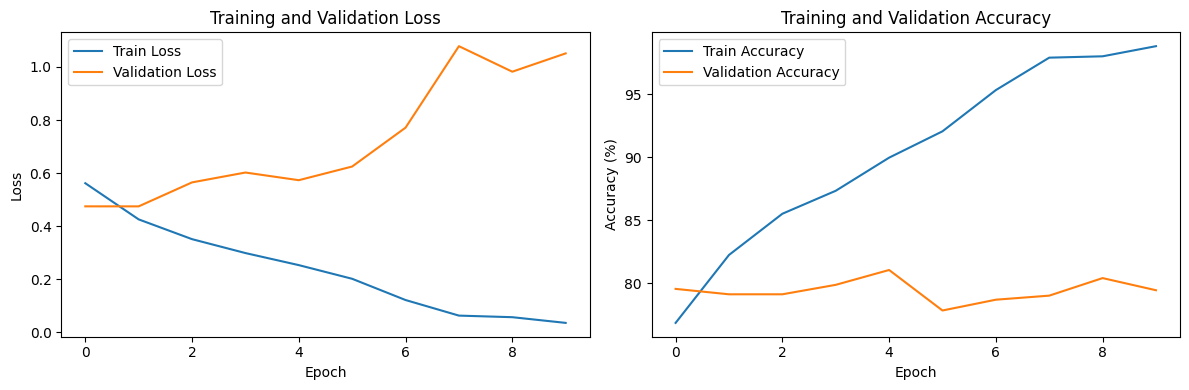

In [18]:
# ================================
# TRAINING
# ================================

def train_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    pbar = tqdm(train_loader, desc="Training")
    for inputs, labels in pbar:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

        pbar.set_postfix({
            'Loss': f'{running_loss/len(train_loader):.4f}',
            'Acc': f'{100.*correct/total:.2f}%'
        })

    return running_loss / len(train_loader), 100. * correct / total

def validate_epoch(model, val_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        pbar = tqdm(val_loader, desc="Validation")
        for inputs, labels in pbar:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

            pbar.set_postfix({
                'Loss': f'{running_loss/len(val_loader):.4f}',
                'Acc': f'{100.*correct/total:.2f}%'
            })

    return running_loss / len(val_loader), 100. * correct / total

# Training loop
train_losses = []
train_accs = []
val_losses = []
val_accs = []
best_val_acc = 0.0

print("Starting training...")
for epoch in range(NUM_EPOCHS):
    print(f"\nEpoch {epoch+1}/{NUM_EPOCHS}")
    print("-" * 50)

    # Train
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    # Validate
    val_loss, val_acc = validate_epoch(model, val_loader, criterion, device)
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    # Learning rate scheduling
    scheduler.step(val_loss)

    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_acc': val_acc,
            'classes': classes
        }, os.path.join(OUTPUT_DIR, f'{MODEL_NAME}_best.pth'))
        print(f"New best model saved! Validation accuracy: {val_acc:.2f}%")

    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

print(f"\nTraining completed! Best validation accuracy: {best_val_acc:.2f}%")

# ================================
# PLOTTING TRAINING CURVES
# ================================

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train Accuracy')
plt.plot(val_accs, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'training_curves.png'))
plt.show()

# 5. Conversion to an ONNX.js Model
After training, we convert our PyTorch model into the ONNX format. This is a special, open-standard format that is recognized by many different tools, including ONNX.js, which allows it to run directly in a web browser.

In [19]:
# ================================
# MODEL CONVERSION FOR BROWSER
# ================================

print("\nConverting model for browser inference...")

# Load best model
checkpoint = torch.load(os.path.join(OUTPUT_DIR, f'{MODEL_NAME}_best.pth'), map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

# Export to ONNX
model.cpu()  # Move to CPU for export
dummy_input = torch.randn(1, 3, IMG_SIZE, IMG_SIZE)

onnx_path = os.path.join(OUTPUT_DIR, f'{MODEL_NAME}.onnx')

try:
    torch.onnx.export(
        model,
        dummy_input,
        onnx_path,
        export_params=True,
        opset_version=10, # Changed opset version to 10 for better compatibility
        do_constant_folding=True,
        input_names=['input'],
        output_names=['output'],
        dynamic_axes={
            'input': {0: 'batch_size'},
            'output': {0: 'batch_size'}
        }
    )
    print(f"Model exported to ONNX: {onnx_path}")
except Exception as e:
    print(f"Error exporting to ONNX: {e}")

# Save class mapping and model info
model_info = {
    'classes': classes,
    'num_classes': len(classes),
    'img_size': IMG_SIZE,
    'input_mean': [0.485, 0.456, 0.406],
    'input_std': [0.229, 0.224, 0.225],
    'best_val_accuracy': best_val_acc,
    'model_name': MODEL_NAME
}

with open(os.path.join(OUTPUT_DIR, f'{MODEL_NAME}_info.json'), 'w') as f:
    json.dump(model_info, f, indent=2)

print(f"Model info saved: {MODEL_NAME}_info.json")


Converting model for browser inference...
Model exported to ONNX: model_output\mobilenet_classifier.onnx
Model info saved: mobilenet_classifier_info.json


## Explanation:

The torch.onnx.export function performs the conversion. It takes our trained model and a dummy_input (a fake image) to trace the model's structure.

opset_version=11 is a specific version of the ONNX format. It's a good practice to stick to a stable version like this one.

dynamic_axes lets the model handle different batch sizes, which is important for flexibility.

A model_info.json file is also created. This is crucial as it stores all the metadata needed for the web page, like the class names and the normalization values, so the browser can prepare images in the exact same way the model was trained.

# 6. Example Code for Browser Inference
The final step is to generate a simple HTML page that uses your new ONNX model. This page will be created for you automatically and includes the necessary code to load the model and perform classifications on images you upload.

In [21]:
# ================================
# GENERATE HTML INFERENCE PAGE
# ================================

html_template = '''<!DOCTYPE html>
<html lang="en" class="dark">
<head>
    <meta charset="UTF-8">
    <meta name="viewport" content="width=device-width, initial-scale=1.0, user-scalable=no">
    <title>AI Dog Breed Classifier</title>
    <script src="https://cdn.jsdelivr.net/npm/onnxruntime-web/dist/ort.min.js"></script>
    <!-- Tailwind CSS CDN -->
    <script src="https://cdn.tailwindcss.com"></script>
    <!-- Font Awesome for icons -->
    <link rel="stylesheet" href="https://cdnjs.cloudflare.com/ajax/libs/font-awesome/6.0.0-beta3/css/all.min.css">
    <style>
        /* Custom CSS variables for light and dark mode */
        :root {
            --light-bg: #f3f4f6;
            --light-card-bg: #ffffff;
            --light-accent-primary: #4f46e5; /* indigo-600 */
            --light-accent-secondary: #8b5cf6; /* violet-500 */
            --light-text-color: #1f2937;
            --light-border-color: #e5e7eb;
            --light-upload-text: #6b7280; /* gray-500 */
            --light-message-info-bg: #e0f2fe; /* blue-100 */
            --light-message-info-color: #2563eb; /* blue-600 */
            --light-message-info-border: #3b82f6; /* blue-500 */
            --light-message-error-bg: #fee2e2; /* red-100 */
            --light-message-error-color: #dc2626; /* red-600 */
            --light-message-error-border: #ef4444; /* red-500 */
            --light-message-success-bg: #dcfce7; /* green-100 */
            --light-message-success-color: #16a34a; /* green-600 */
            --light-message-success-border: #22c55e; /* green-500 */
            --light-sidebar-bg: rgba(255, 255, 255, 0.85); /* Partially transparent white */
            --light-prediction-item-bg: #f9fafb; /* light gray */
        }

        .dark {
            --bg: #1f2937; /* Dark gray */
            --card-bg: #374151; /* Slightly lighter dark gray */
            --accent-primary: #6366f1; /* Indigo-500, brighter for dark mode */
            --accent-secondary: #a78bfa; /* Violet-400, brighter for dark mode */
            --text-color: #d1d5db; /* Light gray for text */
            --border-color: #4b5563; /* Darker border */
            --upload-text: #e0e0e0; /* Lighter gray for upload text, changed from #9ca3af */
            --message-info-bg: #1e3a8a; /* Darker blue */
            --message-info-color: #93c5fd; /* Lighter blue */
            --message-info-border: #3b82f6;
            --message-error-bg: #7f1d1d; /* Darker red */
            --message-error-color: #fca5a5; /* Lighter red */
            --message-error-border: #ef4444;
            --message-success-bg: #166534; /* Darker green */
            --message-success-color: #a7f3d0; /* Lighter green */
            --message-success-border: #22c55e;
            --sidebar-bg: rgba(55, 65, 81, 0.9); /* Darker, partially transparent */
            --prediction-item-bg: #4b5563; /* Darker gray for prediction items */
        }

        /* Fallback for non-dark mode browsers or if dark class is not applied */
        html:not(.dark) {
            --bg: var(--light-bg);
            --card-bg: var(--light-card-bg);
            --accent-primary: var(--light-accent-primary);
            --accent-secondary: var(--light-accent-secondary);
            --text-color: var(--light-text-color);
            --border-color: var(--light-border-color);
            --upload-text: var(--light-upload-text);
            --message-info-bg: var(--light-message-info-bg);
            --message-info-color: var(--light-message-info-color);
            --message-info-border: var(--light-message-info-border);
            --message-error-bg: var(--light-message-error-bg);
            --message-error-color: var(--light-message-error-color);
            --message-error-border: var(--light-message-error-border);
            --message-success-bg: var(--light-message-success-bg);
            --message-success-color: var(--light-message-success-color);
            --message-success-border: var(--light-message-success-border);
            --sidebar-bg: var(--light-sidebar-bg);
            --prediction-item-bg: var(--light-prediction-item-bg);
        }

        /* General styles, using CSS variables */
        * {
            box-sizing: border-box;
            margin: 0;
            padding: 0;
            font-family: 'Inter', sans-serif;
        }

        body {
            min-height: 100vh;
            background-color: var(--bg);
            color: var(--text-color);
            display: flex;
            flex-direction: column;
            align-items: center;
            justify-content: flex-start;
            padding: 0.5rem;
            overflow-x: hidden;
            touch-action: pan-y;
            transition: background-color 0.3s ease, color 0.3s ease; /* Smooth transition for dark mode */
        }

        .main-container {
            width: 100%;
            max-width: 960px;
            display: flex;
            flex-direction: column;
            align-items: center;
            flex-grow: 1;
            background-color: var(--card-bg);
            border-radius: 0.75rem; /* Using radius-lg directly */
            box-shadow: 0 10px 15px -3px rgba(0, 0, 0, 0.1), 0 4px 6px -2px rgba(0, 0, 0, 0.05); /* Using shadow-lg directly */
            padding: 1rem;
            position: relative;
            transition: background-color 0.3s ease, box-shadow 0.3s ease;
        }

        /* Mode Toggle */
        .toggle-bar {
            display: flex;
            width: 100%;
            border-radius: 0.75rem;
            overflow: hidden;
            margin-bottom: 1rem;
            background-color: var(--border-color);
            box-shadow: inset 0 1px 3px rgba(0,0,0,0.1); /* Inner shadow for depth */
        }

        .toggle-btn {
            flex: 1;
            padding: 0.75rem 1rem;
            border: none;
            font-weight: 600;
            cursor: pointer;
            transition: all 0.2s ease-in-out;
            color: var(--text-color);
            background: transparent;
            text-align: center;
            position: relative;
            z-index: 1;
        }

        .toggle-btn::before {
            content: '';
            position: absolute;
            top: 0;
            left: 0;
            right: 0;
            bottom: 0;
            background-color: var(--accent-primary);
            border-radius: 0.75rem;
            z-index: -1;
            transform: scaleX(0);
            transition: transform 0.3s ease-in-out;
            transform-origin: left center;
        }

        .toggle-btn.active {
            color: white; /* Active button text is always white */
        }

        .toggle-btn.active::before {
            transform: scaleX(1);
            box-shadow: 0 4px 6px -1px rgba(0, 0, 0, 0.1), 0 2px 4px -1px rgba(0, 0, 0, 0.06); /* Shadow-md for active button */
        }

        /* Webcam & Upload Areas */
        #uploadArea, #webcamArea {
            width: 100%;
            min-height: 200px;
            max-height: 60vh; /* Responsive height for video, increased for mobile */
            display: none;
            flex-direction: column;
            align-items: center;
            justify-content: center;
        }

        .upload-area {
            border: 2px dashed var(--border-color);
            border-radius: 0.75rem;
            padding: 2rem 1rem;
            text-align: center;
            cursor: pointer;
            transition: all 0.2s ease-in-out;
            color: var(--upload-text);
            display: flex; /* Ensure content is centered */
            flex-direction: column;
            align-items: center;
            justify-content: center;
            font-weight: 500;
        }

        .upload-area:hover {
            border-color: var(--accent-primary);
            background-color: rgba(79, 70, 229, 0.05); /* Light hover for both themes */
        }
        .dark .upload-area:hover {
            background-color: rgba(99, 102, 241, 0.1); /* Darker hover for dark theme */
        }

        .upload-area.dragover {
            background-color: rgba(79, 70, 229, 0.15);
            border-color: var(--accent-primary);
        }
        .dark .upload-area.dragover {
            background-color: rgba(99, 102, 241, 0.25);
        }

        #fileInput {
            display: none;
        }

        /* Video Container */
        .video-container {
            width: 100%;
            height: 60vh; /* Occupy 60% of viewport height on mobile for camera app feel */
            /* aspect-ratio: 16 / 9; /* Removed to allow height to dominate */
            position: relative;
            overflow: hidden;
            border-radius: 0.75rem;
            box-shadow: 0 4px 6px -1px rgba(0, 0, 0, 0.1), 0 2px 4px -1px rgba(0, 0, 0, 0.06);
            background-color: #000;
            display: flex;
            align-items: center;
            justify-content: center;
            margin-bottom: 1rem;
            touch-action: pinch-zoom;
        }

        video, #imagePreview {
            display: block;
            width: 100%;
            height: 100%;
            object-fit: cover; /* Fill the container, might crop */
            transform-origin: center center;
            transition: transform 0.05s ease-out;
            border-radius: 0.75rem; /* Ensure image/video respects container radius */
        }

        /* Overlay Buttons */
        .button-overlay {
            position: absolute;
            background-color: rgba(0, 0, 0, 0.5); /* Slightly darker overlay for better contrast */
            color: white;
            border: none;
            border-radius: 50%;
            display: flex;
            align-items: center;
            justify-content: center;
            cursor: pointer;
            z-index: 10;
            transition: background-color 0.2s ease-in-out, transform 0.2s ease-in-out, box-shadow 0.2s ease-in-out;
            box-shadow: 0 2px 8px rgba(0, 0, 0, 0.3); /* Stronger shadow for floating effect */
        }

        .button-overlay:hover {
            background-color: rgba(0, 0, 0, 0.7);
            transform: translateY(-2px) scale(1.05); /* Slight lift and scale on hover */
        }

        #cameraToggleButton {
            top: 0.75rem;
            right: 0.75rem;
            width: 2.8rem; /* Slightly larger */
            height: 2.8rem;
            font-size: 1.25rem;
        }

        #takePhotoButton {
            bottom: 0.75rem;
            left: 50%;
            transform: translateX(-50%);
            width: 4.5rem; /* Slightly larger */
            height: 4.5rem;
            font-size: 1.75rem;
            background-color: var(--accent-primary); /* Use primary accent color */
            box-shadow: 0 4px 10px rgba(0,0,0,0.4);
        }

        #takePhotoButton.stop-continuous {
            background-color: #ef4444; /* red-500 */
        }
        #takePhotoButton.stop-continuous:hover {
            background-color: #dc2626; /* red-600 */
        }

        /* Zoom Slider */
        .zoom-controls {
            width: 100%;
            margin-bottom: 1rem;
            display: flex;
            flex-direction: column;
            align-items: center;
        }

        input[type="range"] {
            -webkit-appearance: none;
            width: 100%;
            height: 0.6rem; /* Slightly thicker */
            background: var(--border-color);
            border-radius: 0.5rem;
            outline: none;
            opacity: 0.8;
            transition: opacity .2s;
            box-shadow: inset 0 1px 3px rgba(0,0,0,0.1);
        }

        input[type="range"]::-webkit-slider-thumb {
            -webkit-appearance: none;
            appearance: none;
            width: 1.5rem; /* Larger thumb */
            height: 1.5rem;
            border-radius: 50%;
            background: var(--accent-primary);
            cursor: grab; /* Indicate draggable */
            box-shadow: 0 0 8px rgba(0, 0, 0, 0.4); /* Stronger shadow for thumb */
            border: 2px solid var(--card-bg); /* Border for thumb */
            transition: background-color 0.2s ease, transform 0.1s ease;
        }
        input[type="range"]::-webkit-slider-thumb:active {
            cursor: grabbing;
            transform: scale(1.1);
        }


        /* Loading & Messages */
        #loading {
            display: none;
            text-align: center;
            margin: 1rem 0;
            color: var(--text-color);
        }

        .spinner {
            width: 32px; /* Larger spinner */
            height: 32px;
            border: 4px solid rgba(0, 0, 0, .2); /* Thicker border */
            border-top-color: var(--accent-primary);
            border-radius: 50%;
            animation: spin 1s linear infinite;
            margin: 0 auto 8px;
        }

        @keyframes spin {
            to {
                transform: rotate(360deg);
            }
        }

        #messageBox {
            padding: 0.75rem;
            border-radius: 0.5rem;
            text-align: center;
            font-weight: 600;
            display: none;
            width: 100%;
            margin-top: 1rem;
            box-shadow: 0 1px 3px rgba(0,0,0,0.1);
        }

        #messageBox.error {
            background-color: var(--message-error-bg);
            color: var(--message-error-color);
            border: 1px solid var(--message-error-border);
        }

        #messageBox.success {
            background-color: var(--message-success-bg);
            color: var(--message-success-color);
            border: 1px solid var(--message-success-border);
        }

        #messageBox.info {
            background-color: var(--message-info-bg);
            color: var(--message-info-color);
            border: 1px solid var(--message-info-border);
        }

        /* Predictions Sidebar */
        #predictionsSidebar {
            position: fixed;
            top: 0;
            right: -100vw; /* Hidden off-screen, full width on mobile */
            width: 100vw; /* Occupy full width on mobile */
            max-width: 350px; /* Limit width on larger screens to prevent it from being too wide */
            height: 100vh;
            background: var(--sidebar-bg); /* Use CSS variable */
            backdrop-filter: blur(8px);
            box-shadow: -4px 0 10px rgba(0, 0, 0, 0.2);
            transition: right 0.3s ease-in-out;
            z-index: 100;
            display: flex;
            flex-direction: column;
            padding: 1rem;
            color: var(--text-color);
        }

        #predictionsSidebar.open {
            right: 0;
        }

        .predictions-header {
            display: flex;
            justify-content: space-between;
            align-items: center;
            margin-bottom: 1rem;
            padding-bottom: 0.5rem;
            border-bottom: 1px solid var(--border-color);
        }

        .predictions-header h3 {
            font-size: 1.4rem; /* Slightly larger heading */
            font-weight: 700;
            color: var(--accent-primary); /* Highlight header */
        }

        .predictions-header button {
            background: none;
            border: none;
            font-size: 1.75rem; /* Larger icon */
            cursor: pointer;
            color: var(--text-color); /* Use general text color */
            padding: 0.25rem;
            border-radius: 50%;
            transition: background-color 0.2s, color 0.2s;
        }

        .predictions-header button:hover {
            background-color: var(--border-color);
            color: var(--accent-primary);
        }

        .predictions-content {
            flex-grow: 1;
            overflow-y: auto;
            padding-right: 5px; /* Add some padding for scrollbar */
        }
        /* Custom scrollbar for predictions content */
        .predictions-content::-webkit-scrollbar {
            width: 8px;
        }
        .predictions-content::-webkit-scrollbar-track {
            background: var(--border-color);
            border-radius: 10px;
        }
        .predictions-content::-webkit-scrollbar-thumb {
            background: var(--accent-primary);
            border-radius: 10px;
        }
        .predictions-content::-webkit-scrollbar-thumb:hover {
            background: var(--accent-secondary);
        }


        .prediction-item {
            display: flex;
            flex-direction: column;
            background-color: var(--prediction-item-bg);
            margin-bottom: 0.75rem; /* More spacing */
            padding: 1rem;
            border-radius: 0.5rem;
            border: 1px solid var(--border-color);
            box-shadow: 0 2px 4px rgba(0, 0, 0, 0.1); /* Stronger shadow */
            transition: transform 0.2s ease, box-shadow 0.2s ease;
        }
        .prediction-item:hover {
            transform: translateY(-2px);
            box-shadow: 0 4px 8px rgba(0, 0, 0, 0.15);
        }

        .prediction-item span:first-child {
            font-weight: 700; /* Bolder class name */
            margin-bottom: 0.5rem;
            color: var(--accent-primary);
            font-size: 1.1rem;
        }

        .prediction-details {
            display: flex;
            align-items: center;
            justify-content: space-between;
            width: 100%;
        }

        .confidence-bar {
            flex-grow: 1;
            height: 0.8rem; /* Thicker bar */
            background: var(--border-color);
            border-radius: 0.4rem;
            overflow: hidden;
            margin-left: 0.75rem; /* More space */
            box-shadow: inset 0 1px 3px rgba(0,0,0,0.1);
        }

        .confidence-fill {
            height: 100%;
            background: linear-gradient(90deg, var(--accent-primary), var(--accent-secondary));
            transition: width .6s ease-out; /* Slower transition for a smoother animation */
            border-radius: 0.4rem; /* Match parent radius */
        }

        /* Mini Predictions Button (when sidebar is closed) */
        .mini-predictions-container {
            position: fixed;
            bottom: 1.5rem; /* Move up slightly */
            right: 1.5rem; /* Move in slightly */
            background-color: var(--sidebar-bg);
            backdrop-filter: blur(8px);
            border-radius: 9999px;
            padding: 0.6rem 1.2rem; /* More padding */
            display: flex;
            align-items: center;
            color: var(--text-color);
            gap: 0.75rem; /* More gap */
            box-shadow: 0 4px 10px rgba(0,0,0,0.2); /* Stronger shadow */
            z-index: 90;
            transition: transform 0.3s ease-in-out, opacity 0.3s ease-in-out;
            cursor: pointer;
            border: 1px solid var(--border-color); /* Add border */
        }

        .mini-predictions-container.hidden {
            opacity: 0;
            pointer-events: none;
            transform: translateY(20px);
        }

        .mini-predictions-container #openPredictionsButton {
            background-color: var(--accent-primary);
            color: white;
            border-radius: 50%;
            width: 2.5rem; /* Larger button */
            height: 2.5rem;
            font-size: 1.1rem;
            transition: background-color 0.2s, transform 0.2s;
            box-shadow: 0 2px 5px rgba(0, 0, 0, 0.2);
        }
        .mini-predictions-container #openPredictionsButton:hover {
            background-color: var(--accent-secondary);
            transform: scale(1.05);
        }

        /* Live Prediction Display */
        #livePredictionDisplay {
            min-height: 48px;
            display: flex;
            align-items: center;
            justify-content: center;
            transition: opacity 0.3s ease-in-out;
            text-align: center;
            padding: 0.75rem 1.25rem; /* More padding */
            border-radius: 0.5rem;
            background-color: var(--message-info-bg); /* Use info message background */
            color: var(--message-info-color); /* Use info message color */
            font-weight: 600;
            width: 100%;
            box-shadow: 0 1px 3px rgba(0,0,0,0.1);
            margin-bottom: 1rem;
            border: 1px solid var(--message-info-border);
        }
        .dark #livePredictionDisplay {
             background-color: var(--message-info-bg);
             color: var(--message-info-color);
        }


        /* Desktop Layout - Side-by-side */
        @media (min-width: 768px) {
            body {
                padding: 1rem; /* More padding on desktop */
            }
            .main-container {
                flex-direction: row;
                justify-content: space-between;
                align-items: flex-start;
                padding: 1.5rem;
            }

            .main-content {
                flex: 1;
                max-width: calc(100% - 350px - 2rem); /* Account for sidebar width + gap, adjust for new max-width */
                margin-right: 2rem; /* Larger gap */
            }

            .video-container {
                height: 50vh; /* Revert to 50vh for desktop */
                aspect-ratio: 16 / 9; /* Re-add aspect ratio for desktop */
                max-width: none; /* No max width for video on desktop */
                min-height: 400px; /* Ensure a decent height */
            }

            #predictionsSidebar {
                position: static;
                width: 350px; /* Slightly wider sidebar on desktop */
                height: auto;
                min-height: 500px; /* Consistent height */
                box-shadow: none;
                border-left: 1px solid var(--border-color);
                border-radius: 0;
                right: auto;
                transition: none;
                background: var(--card-bg);
                backdrop-filter: none;
            }

            #predictionsSidebar .predictions-header button {
                display: none;
            }
            .mini-predictions-container {
                display: none !important;
            }
            #miniPredictionText {
                color: var(--text-color);
                user-select: none;
                pointer-events: none;
            }
            #initialMessage {
                display: none;
            }
            #livePredictionDisplay {
                display: none !important;
            }
        }
    </style>
</head>

<body>
    <div class="main-container">
        <!-- Main Content Area -->
        <div class="main-content flex flex-col items-center w-full">
            <h3 class="font-extrabold mb-2 text-center text-gray-800 dark:text-white text-2xl">AI Classifier</h3>
            <p id="initialMessage" class="text-sm text-gray-600 dark:text-gray-200 mb-4 text-center">Choose an input source below to get started!</p>
            <div id="livePredictionDisplay" class="hidden">
                <!-- Live prediction will appear here -->
            </div>

            <!-- Mode toggle -->
            <div class="toggle-bar mb-6">
                <button id="uploadToggle" class="toggle-btn active"> <i class="fas fa-cloud-upload-alt mr-2"></i> Upload</button>
                <button id="webcamToggle" class="toggle-btn"><i class="fas fa-video mr-2"></i> Webcam</button>
            </div>

            <!-- Upload panel -->
            <div id="uploadArea" class="upload-area w-full mb-6">
                <i class="fas fa-file-upload text-4xl mb-3"></i>
                Drop an image here or click to browse
                <input type="file" id="fileInput" accept="image/*" />
            </div>

            <!-- Uploaded Image Preview (shown only in Upload mode when an image is loaded) -->
            <div id="uploadedImagePreviewContainer" class="hidden w-full min-h-[250px] max-h-[60vh] overflow-hidden rounded-lg mb-6 bg-gray-100 dark:bg-gray-700 flex items-center justify-center p-2 border border-gray-200 dark:border-gray-600">
                <img id="uploadedImageDisplay" class="max-w-full max-h-full object-contain" alt="Uploaded Image Preview" />
            </div>

            <!-- Webcam panel (initially hidden) -->
            <div id="webcamArea" class="w-full">
                <div id="videoContainer" class="video-container">
                    <video id="cameraFeed" autoplay playsinline></video>
                    <img id="imagePreview" alt="Captured Frame" style="display:none;" />
                    <p id="noCameraMessage" class="absolute text-white text-center p-4 hidden bg-black bg-opacity-70 rounded-md">
                        Camera not available or access denied. Please allow camera permissions.
                    </p>
                    <button id="cameraToggleButton" class="button-overlay hidden">
                        <i class="fas fa-sync-alt"></i> <!-- Icon for camera switch -->
                    </button>
                    <button id="takePhotoButton" class="button-overlay">
                        <i class="fas fa-play"></i> <!-- Play icon initially -->
                    </button>
                </div>

                <!-- Zoom Slider (only shown in webcam mode) -->
                <div id="zoomControls" class="zoom-controls hidden mt-4">
                    <label for="zoomSlider" class="text-base font-medium mb-2 text-gray-700 dark:text-gray-200">Zoom Level: <span id="zoomValue">1.0</span>x</label>
                    <input type="range" id="zoomSlider" min="1.0" max="4.0" value="1.0" step="0.1">
                </div>
            </div>

            <div id="loading" class="hidden flex flex-col items-center mt-4">
                <div class="spinner"></div>
                <p class="text-gray-700 dark:text-gray-200 text-sm">Processing...</p>
            </div>

            <div id="messageBox" class="message-box hidden"></div>
        </div>

        <!-- Predictions Sidebar -->
        <div id="predictionsSidebar" class="predictions-sidebar">
            <div class="predictions-header">
                <h3>Top Predictions</h3>
                <button id="closePredictions">
                    <i class="fas fa-times"></i>
                </button>
            </div>
            <div id="predictionsContent" class="predictions-content">
                <!-- Prediction items will be dynamically inserted here -->
                <p class="text-gray-500 dark:text-gray-200 text-sm mt-2">Upload an image or start your webcam to see predictions!</p>
            </div>
        </div>

        <!-- Mini Predictions Button (when sidebar is closed on mobile) -->
        <div id="miniPredictions" class="mini-predictions-container hidden">
            <span id="miniPredictionText" class="text-sm font-semibold"></span>
            <button id="openPredictionsButton">
                <i class="fas fa-chart-bar"></i>
            </button>
        </div>
    </div>

    <script>
        const MODEL_CONFIG = ''' + json.dumps(model_info) + ''';
        const MODEL_INPUT_NAME = 'input';
        let session = null;
        let webcamStream = null;
        let liveInterval = null; // Interval for continuous prediction
        let continuousPredictionActive = false; // Flag for continuous prediction state
        let isSidebarManuallyClosed = false; // New: Tracks if user explicitly closed sidebar

        const $ = id => document.getElementById(id);

        // UI Element References
        const cameraFeed = $('cameraFeed');
        const imagePreview = $('imagePreview'); // Used for captured webcam frames
        const uploadedImageDisplay = $('uploadedImageDisplay'); // Used for uploaded image preview
        const uploadedImagePreviewContainer = $('uploadedImagePreviewContainer'); // Container for uploaded image
        const zoomSlider = $('zoomSlider');
        const zoomValueSpan = $('zoomValue');
        const noCameraMessage = $('noCameraMessage');
        const messageBox = $('messageBox');
        const videoContainer = $('videoContainer');
        const cameraToggleButton = $('cameraToggleButton');
        const takePhotoButton = $('takePhotoButton'); // Renamed from startStopButton
        const uploadToggle = $('uploadToggle');
        const webcamToggle = $('webcamToggle');
        const uploadArea = $('uploadArea');
        const webcamArea = $('webcamArea');
        const fileInput = $('fileInput');
        const loadingSpinner = $('loading');
        const predictionsSidebar = $('predictionsSidebar');
        const predictionsContent = $('predictionsContent');
        const closePredictionsButton = $('closePredictions');
        const zoomControls = $('zoomControls');
        const miniPredictions = $('miniPredictions'); // New: Mini predictions container
        const miniPredictionText = $('miniPredictionText'); // New: Text for mini predictions
        const openPredictionsButton = $('openPredictionsButton'); // New: Button to open sidebar from mini view
        const initialMessage = $('initialMessage'); // Reference to the initial message paragraph
        const livePredictionDisplay = $('livePredictionDisplay'); // New: Live prediction display element


        let currentZoom = 1.0;
        const MIN_ZOOM = 1.0;
        const MAX_ZOOM = 4.0;
        let isFrontCamera = false; // Tracks current camera facing mode

        // For pinch-to-zoom
        let initialPinchDistance = -1;
        let lastZoom = MIN_ZOOM;

        /* --- Helpers --- */
        function isMobileDevice() {
            return (
                /Android|webOS|iPhone|iPad|iPod|BlackBerry|IEMobile|Opera Mini/i.test(navigator.userAgent) ||
                (navigator.maxTouchPoints > 0 && navigator.userAgent.includes("Mobi"))
            );
        }

        function showMessage(message, type = 'info') {
            messageBox.textContent = message;
            messageBox.className = `message-box ${type}`;
            messageBox.style.display = 'block';
            setTimeout(() => messageBox.style.display = 'none', 4000);
        }

        function applyZoom(zoomLevel) {
            currentZoom = Math.max(MIN_ZOOM, Math.min(MAX_ZOOM, zoomLevel));
            cameraFeed.style.transform = `scale(${currentZoom})`;
            zoomSlider.value = currentZoom.toFixed(1);
            zoomValueSpan.textContent = currentZoom.toFixed(1);
        }

        function showPredictionsSidebar(force = false) { // Added force flag
            if (!isSidebarManuallyClosed || force) { // Only open if not manually closed OR forced (e.g., new prediction)
                predictionsSidebar.classList.add('open');
                miniPredictions.classList.add('hidden'); // Hide mini button when sidebar is open
            }
            updateClosedSidebarDisplay(); // Always update to ensure correct state
        }

        function hidePredictionsSidebar() {
            predictionsSidebar.classList.remove('open');
            isSidebarManuallyClosed = true; // Mark as manually closed
            updateClosedSidebarDisplay(); // Show the mini display
        }

        // Updates the visibility and content of the mini prediction button and live prediction display
        function updateClosedSidebarDisplay() {
            // Only show mini-predictions if sidebar is closed AND there are actual predictions to display
            // AND only on mobile
            if (!predictionsSidebar.classList.contains('open') && predictionsContent.children.length > 0 && isMobileDevice()) {
                miniPredictions.classList.remove('hidden');
                livePredictionDisplay.classList.add('hidden');
            } else {
                miniPredictions.classList.add('hidden');
                livePredictionDisplay.classList.remove('hidden');
            }

            // Manage livePredictionDisplay visibility based on continuous mode and sidebar state
            if (continuousPredictionActive && !predictionsSidebar.classList.contains('open') && isMobileDevice()) { // Only show on mobile
                livePredictionDisplay.classList.add('hidden');
                initialMessage.classList.add('hidden'); // Hide initial message
            } else {
                livePredictionDisplay.classList.remove('hidden');
                // Show initial message only if no live prediction is active AND (not on mobile OR camera is stopped/not started)
                if (!continuousPredictionActive && (!webcamStream || !predictionsContent.children.length || !isMobileDevice())) {
                    initialMessage.classList.remove('hidden');
                } else if (isMobileDevice() && webcamStream && !continuousPredictionActive) {
                    // if webcam is showing static image (i.e. not continuous prediction), hide initial message
                    initialMessage.classList.add('hidden');
                } else {
                    initialMessage.classList.add('hidden'); // Default to hidden if live display is shown or not applicable
                }
            }
        }

        /* --- Model & Prediction --- */
        async function initModel() {
            try {
                session = await ort.InferenceSession.create('./''' + MODEL_NAME + '''.onnx', {
                    executionProviders: ['wasm']
                });
                showMessage('Model ready!', 'success');
            } catch (e) {
                showMessage('Model error: ' + e.message, 'error');
            }
        }

        function preprocess(src) {
            const { input_mean, input_std, img_size } = MODEL_CONFIG;
            const cvs = document.createElement('canvas');
            cvs.width = cvs.height = img_size;
            const ctx = cvs.getContext('2d');
            ctx.drawImage(src, 0, 0, img_size, img_size);
            const d = ctx.getImageData(0, 0, img_size, img_size).data;
            const t = new Float32Array(3 * img_size * img_size);
            for (let i = 0; i < img_size * img_size; i++) {
                t[i] = (d[i * 4] / 255 - input_mean[0]) / input_std[0];
                t[img_size * img_size + i] = (d[i * 4 + 1] / 255 - input_mean[1]) / input_std[1];
                t[2 * img_size * img_size + i] = (d[i * 4 + 2] / 255 - input_mean[2]) / input_std[2];
            }
            return t;
        }

        async function predict(src, forceSidebarOpen = true) { // Default to true for explicit captures/uploads
            if (!session) {
                showMessage('Model not ready', 'info');
                return;
            }
            loadingSpinner.style.display = 'flex'; // Show spinner

            try {
                const data = preprocess(src);
                const tensor = new ort.Tensor('float32', data, [1, 3, 224, 224]);
                const outMap = await session.run({ [MODEL_INPUT_NAME]: tensor });
                const logits = Array.from(outMap[Object.keys(outMap)[0]].data);
                const max = Math.max(...logits);
                const probs = logits.map(l => Math.exp(l - max));
                const sum = probs.reduce((a, b) => a + b, 0);
                const results = probs.map((p, i) => ({
                    class: MODEL_CONFIG.classes[i],
                    confidence: p / sum
                })).sort((a, b) => b.confidence - a.confidence);
                displayResults(results);
                showPredictionsSidebar(forceSidebarOpen); // Show sidebar with new results, respecting force flag
            } catch (e) {
                showMessage('Prediction failed: ' + e.message, 'error');
            } finally {
                loadingSpinner.style.display = 'none'; // Hide spinner
            }
        }

        function displayResults(res) {
            predictionsContent.innerHTML = ''; // Clear previous results
            res.slice(0, 5).forEach((r, i) => { // Added index 'i'
                const pct = (r.confidence * 100).toFixed(1);

                const predictionItem = document.createElement('div');
                predictionItem.className = 'prediction-item';

                const classNameSpan = document.createElement('span');
                classNameSpan.textContent = r.class;

                const predictionDetailsDiv = document.createElement('div');
                predictionDetailsDiv.className = 'prediction-details';

                const percentageSpan = document.createElement('span');
                percentageSpan.textContent = `${pct}%`;

                const confidenceBarDiv = document.createElement('div');
                confidenceBarDiv.className = 'confidence-bar';

                const confidenceFillDiv = document.createElement('div');
                confidenceFillDiv.className = 'confidence-fill';
                confidenceFillDiv.style.width = `${pct}%`;

                confidenceBarDiv.appendChild(confidenceFillDiv);
                predictionDetailsDiv.appendChild(percentageSpan);
                predictionDetailsDiv.appendChild(confidenceBarDiv);

                predictionItem.appendChild(classNameSpan);
                predictionItem.appendChild(predictionDetailsDiv);

                predictionsContent.appendChild(predictionItem);
            });

            // Update mini prediction display
            const topPrediction = res[0];
            if (topPrediction) {
                miniPredictionText.textContent = `${topPrediction.class} ${topPrediction.confidence * 100 > 0.1 ? (topPrediction.confidence * 100).toFixed(1) : '<0.1'}%`;
                livePredictionDisplay.textContent = `${topPrediction.class} (${(topPrediction.confidence * 100).toFixed(1)}%)`; // Removed "Live:"
            } else {
                miniPredictionText.textContent = 'No predictions.';
                livePredictionDisplay.textContent = 'No live prediction.';
            }
            updateClosedSidebarDisplay(); // Ensure mini button and live display visibility is managed
        }

        /* --- Webcam Logic --- */
        async function startWebcam() {
            if (webcamStream) { // Stop existing stream if any
                stopWebcam();
            }

            // Temporarily disable button to prevent multiple clicks while camera is starting
            takePhotoButton.disabled = true;

            const videoConstraints = {
                facingMode: isFrontCamera ? 'user' : 'environment'
            };

            try {
                webcamStream = await navigator.mediaDevices.getUserMedia({ video: videoConstraints });
                cameraFeed.srcObject = webcamStream;
                cameraFeed.style.display = 'block'; // Show live video
                imagePreview.style.display = 'none'; // Hide static image
                noCameraMessage.classList.add('hidden'); // Hide "no camera" message
                cameraToggleButton.classList.remove('hidden'); // Show toggle button
                applyZoom(MIN_ZOOM); // Reset zoom to 1x and apply
                zoomControls.classList.remove('hidden'); // Show zoom slider

                const cameraName = isFrontCamera ? 'Front Camera' : 'Back Camera';
                showMessage(`${cameraName} started! Continuous prediction active.`, 'success');

                isSidebarManuallyClosed = false; // Reset sidebar state when starting camera
                startContinuousPrediction(); // Start continuous prediction by default
                initialMessage.classList.add('hidden'); // Hide initial message when camera starts

            } catch (err) {
                console.error('Error accessing camera: ', err);
                cameraFeed.style.display = 'none';
                imagePreview.style.display = 'none';
                noCameraMessage.classList.remove('hidden'); // Show "no camera" message
                let errorMessage = 'Failed to start camera. ';
                if (err.name === 'NotAllowedError') {
                    errorMessage += 'Permission denied by user.';
                } else if (err.name === 'NotFoundError') {
                    errorMessage += 'No camera found.';
                } else if (err.name === 'OverconstrainedError') {
                    errorMessage += 'The requested camera (front/back) is not available or its constraints cannot be met. Try toggling.';
                } else {
                    errorMessage += 'Please ensure camera permissions are granted and no other app is using the camera.';
                }
                showMessage(errorMessage, 'error');
                cameraToggleButton.classList.add('hidden'); // Hide toggle if camera fails
                zoomControls.classList.add('hidden'); // Hide zoom slider
                stopContinuousPrediction(); // Ensure continuous prediction is stopped on error
                hidePredictionsSidebar(); // Ensure sidebar is hidden on camera error
                initialMessage.classList.remove('hidden'); // Show initial message on camera error
            } finally {
                takePhotoButton.disabled = false; // Always re-enable the button
            }
        }

        function stopWebcam() {
            stopContinuousPrediction(); // Stop continuous prediction
            if (webcamStream) {
                webcamStream.getTracks().forEach(track => track.stop());
                webcamStream = null;
            }
            cameraFeed.srcObject = null;
            cameraFeed.style.display = 'none'; // Hide video
            imagePreview.style.display = 'none'; // Hide any static image
            noCameraMessage.classList.remove('hidden'); // Show message
            noCameraMessage.textContent = 'Camera stopped. Press the Play button to start.'; // Update message
            cameraToggleButton.classList.add('hidden'); // Hide camera toggle
            zoomControls.classList.add('hidden'); // Hide zoom slider
            applyZoom(MIN_ZOOM); // Reset zoom
            hidePredictionsSidebar(); // Hide predictions and mini button
            isSidebarManuallyClosed = false; // Reset manual close state for next camera start

            takePhotoButton.innerHTML = '<i class="fas fa-play"></i>'; // Reset button to play
            takePhotoButton.classList.remove('stop-continuous'); // Ensure no red background
            takePhotoButton.disabled = false; // Ensure button is enabled
            showMessage('Camera stopped.', 'info');
            initialMessage.classList.remove('hidden'); // Show initial message
        }

        async function switchCamera() {
            isFrontCamera = !isFrontCamera; // Toggle camera state
            await startWebcam(); // Restart camera with new facing mode
        }

        function captureFrameForPrediction() {
            // Create a temporary canvas to draw the current video frame
            const v = cameraFeed;
            if (!v.videoWidth || !v.videoHeight) {
                showMessage('Video stream not ready for capture.', 'error');
                return;
            }
            const cvs = document.createElement('canvas');
            cvs.width = v.videoWidth;
            cvs.height = v.videoHeight;

            // Calculate source rectangle for zoomed-in portion
            const sx = (v.videoWidth - (v.videoWidth / currentZoom)) / 2;
            const sy = (v.videoHeight - (v.videoHeight / currentZoom)) / 2;
            const sWidth = v.videoWidth / currentZoom;
            const sHeight = v.videoHeight / currentZoom;

            // Draw the zoomed portion onto the canvas
            cvs.getContext('2d').drawImage(v, sx, sy, sWidth, sHeight, 0, 0, cvs.width, cvs.height);

            // Create a NEW Image object for this specific prediction
            const imgForPrediction = new Image();
            imgForPrediction.onload = () => {
                // Update the visible image preview
                imagePreview.src = imgForPrediction.src;
                imagePreview.style.display = 'block';
                cameraFeed.style.display = 'none';

                isSidebarManuallyClosed = false; // A new capture should open the sidebar
                predict(imgForPrediction, true); // Predict using the NEW Image object, force sidebar open
                showMessage('Photo captured! Displaying predictions.', 'info');
            };
            imgForPrediction.src = cvs.toDataURL('image/jpeg');
        }

        function startContinuousPrediction() {
            if (liveInterval) clearInterval(liveInterval); // Clear any old interval
            liveInterval = setInterval(() => {
                if (cameraFeed.readyState === cameraFeed.HAVE_ENOUGH_DATA) { // Ensure video is ready
                    const cvs = document.createElement('canvas');
                    cvs.width = cameraFeed.videoWidth;
                    cvs.height = cameraFeed.videoHeight;

                    // Calculate source rectangle for zoomed-in portion
                    const sx = (cameraFeed.videoWidth - (cameraFeed.videoWidth / currentZoom)) / 2;
                    const sy = (cameraFeed.videoHeight - (cameraFeed.videoHeight / currentZoom)) / 2;
                    const sWidth = cameraFeed.videoWidth / currentZoom;
                    const sHeight = cameraFeed.videoHeight / currentZoom;

                    // Draw the zoomed portion onto the canvas
                    cvs.getContext('2d').drawImage(cameraFeed, sx, sy, sWidth, sHeight, 0, 0, cvs.width, cvs.height);

                    const img = new Image();
                    img.onload = () => predict(img, false); // Pass false to indicate continuous mode prediction (don't force sidebar open)
                    img.src = cvs.toDataURL('image/jpeg');
                }
            }, 100); // Predict every 0.1 seconds for continuous mode
            continuousPredictionActive = true;
            cameraFeed.style.display = 'block'; // Ensure live video is shown when continuous starts
            imagePreview.style.display = 'none'; // Hide static image if resuming continuous
            takePhotoButton.innerHTML = '<i class="fas fa-pause"></i>'; // Change icon to pause continuous
            takePhotoButton.classList.add('stop-continuous'); // Style as 'stop' button
            showMessage('Continuous prediction started.', 'success');
            livePredictionDisplay.classList.remove('hidden'); // Show live prediction display
            initialMessage.classList.add('hidden'); // Hide initial message
        }

        function stopContinuousPrediction() {
            if (liveInterval) {
                clearInterval(liveInterval);
                liveInterval = null;
            }
            continuousPredictionActive = false;
            if (webcamStream) { // Only change button if camera is still active
                takePhotoButton.innerHTML = '<i class="fas fa-camera"></i>'; // Change icon to take photo
                takePhotoButton.classList.remove('stop-continuous'); // Reset button style
            }
            showMessage('Continuous prediction paused.', 'info');
            livePredictionDisplay.classList.add('hidden'); // Hide live prediction display
            updateClosedSidebarDisplay(); // Ensure mini button / initial message is correct after stopping continuous
        }

        /* --- UI Mode Switch --- */
        function setMode(mode) {
            uploadToggle.classList.remove('active');
            webcamToggle.classList.remove('active');
            uploadArea.style.display = 'none';
            webcamArea.style.display = 'none';
            imagePreview.style.display = 'none'; // Hide webcam preview image
            uploadedImagePreviewContainer.classList.add('hidden'); // Hide uploaded image preview
            hidePredictionsSidebar(); // Hide any existing predictions and mini button
            isSidebarManuallyClosed = false; // Reset manual close state on mode switch

            livePredictionDisplay.classList.add('hidden'); // Hide live prediction display
            initialMessage.classList.remove('hidden'); // Show initial message by default

            if (mode === 'upload') {
                uploadToggle.classList.add('active');
                uploadArea.style.display = 'flex'; // Use flex for centering content
                stopWebcam(); // Ensure webcam is stopped when switching to upload
                // The uploadedImagePreviewContainer will be shown by handleFile
            } else { // mode === 'webcam'
                webcamToggle.classList.add('active');
                webcamArea.style.display = 'block';
                // The webcam starts upon activating this mode via startWebcam() call
                startWebcam(); // This will handle showing camera feed and initial messages
            }
        }

        /* --- Event Wiring --- */
        window.addEventListener('DOMContentLoaded', () => {
            // Set dark mode as default
            document.documentElement.classList.add('dark');

            initModel(); // Initialize ONNX model

            // Mode toggles
            uploadToggle.addEventListener('click', () => setMode('upload'));
            webcamToggle.addEventListener('click', () => setMode('webcam'));

            // Upload functionality
            uploadArea.addEventListener('click', () => fileInput.click());
            fileInput.addEventListener('change', e => handleFile(e.target.files[0]));
            ['dragover', 'dragleave', 'drop'].forEach(evt => {
                uploadArea.addEventListener(evt, e => {
                    e.preventDefault();
                    uploadArea.classList.toggle('dragover', evt === 'dragover');
                    if (evt === 'drop' && e.dataTransfer.files.length) handleFile(e.dataTransfer.files[0]);
                });
            });

            // Webcam controls
            cameraToggleButton.addEventListener('click', switchCamera);
            takePhotoButton.addEventListener('click', () => {
                if (!webcamStream) { // State: Camera OFF (Play icon)
                    startWebcam(); // This starts continuous prediction
                } else { // State: Camera ON (Pause or Camera icon)
                    if (continuousPredictionActive) { // State: Continuous LIVE (Pause icon)
                        // User wants to pause continuous and capture a single frame
                        stopContinuousPrediction(); // This will change button to fa-camera
                        captureFrameForPrediction(); // Capture and predict
                    } else { // State: Continuous PAUSED/FROZEN (Camera icon)
                        // User wants to resume continuous live prediction
                        startContinuousPrediction(); // This will change button to fa-pause
                        hidePredictionsSidebar(); // Hide sidebar when returning to continuous
                    }
                }
            });


            // Zoom slider
            zoomSlider.addEventListener('input', (event) => {
                const zoomLevel = parseFloat(event.target.value);
                applyZoom(zoomLevel);
            });

            // Pinch-to-zoom logic (only for mobile devices)
            if (isMobileDevice()) {
                videoContainer.addEventListener('touchstart', (e) => {
                    if (e.touches.length === 2) {
                        initialPinchDistance = Math.hypot(
                            e.touches[0].clientX - e.touches[1].clientX,
                            e.touches[0].clientY - e.touches[1].clientY
                        );
                        lastZoom = currentZoom; // Store current zoom to base relative changes
                        e.preventDefault(); // Prevent default browser gestures like page zoom
                    }
                });

                videoContainer.addEventListener('touchmove', (e) => {
                    if (e.touches.length === 2 && initialPinchDistance > 0) {
                        const currentPinchDistance = Math.hypot(
                            e.touches[0].clientX - e.touches[1].clientX,
                            e.touches[0].clientY - e.touches[1].clientY
                        );

                        const scaleFactor = currentPinchDistance / initialPinchDistance;
                        let newZoom = lastZoom * scaleFactor;

                        applyZoom(newZoom);
                        e.preventDefault(); // Prevent default browser gestures
                    }
                });

                videoContainer.addEventListener('touchend', () => {
                    initialPinchDistance = -1; // Reset pinch state
                });
                videoContainer.addEventListener('touchcancel', () => { // Handle cases where touch is interrupted
                    initialPinchDistance = -1;
                });
            }

            // Close predictions sidebar
            closePredictionsButton.addEventListener('click', hidePredictionsSidebar);
            // Open predictions sidebar from mini button
            openPredictionsButton.addEventListener('click', () => {
                isSidebarManuallyClosed = false; // Reset manual close flag
                showPredictionsSidebar(true); // Force sidebar open
            });


            // Default mode on load
            setMode('upload');
        });

        /* --- File Handling for Upload Mode --- */
        function handleFile(file) {
            if (!file.type.startsWith('image/')) {
                showMessage('Please choose an image file (e.g., JPG, PNG).', 'error');
                return;
            }
            const reader = new FileReader();
            reader.onload = e => {
                const img = new Image();
                img.onload = () => {
                    uploadedImageDisplay.src = e.target.result; // Set new image
                    uploadedImagePreviewContainer.classList.remove('hidden'); // Show container

                    // Ensure no other preview elements are showing if coming from webcam mode
                    imagePreview.style.display = 'none';
                    cameraFeed.style.display = 'none';

                    isSidebarManuallyClosed = false; // A new upload should open the sidebar
                    predict(img, true); // Run prediction, force sidebar open
                };
                img.src = e.target.result;
            };
            reader.readAsDataURL(file);
        }
    </script>
</body>
</html>'''

# Save HTML file
html_path = os.path.join(OUTPUT_DIR, 'inference.html')
with open(html_path, 'w') as f:
    f.write(html_template)

print(f"HTML inference page saved: {html_path}")

# ================================
# FINAL SUMMARY
# ================================

print("\n" + "="*60)
print("🎉 PIPELINE COMPLETED SUCCESSFULLY!")
print("="*60)
print(f"📁 Output directory: {OUTPUT_DIR}/")
print(f"🤖 Model file: {MODEL_NAME}.onnx")
print(f"📄 Model info: {MODEL_NAME}_info.json")
print(f"🌐 Web interface: inference.html")
print(f"📊 Training curves: training_curves.png")
print(f"🏆 Best validation accuracy: {best_val_acc:.2f}%")
print(f"📝 Number of classes: {len(classes)}")
print(f"🏷️ Classes: {', '.join(classes)}")
print("\n📋 To use the model in a browser:")
print("1. Copy the .onnx file, .json file, and .html file to a web server")
print("2. Open inference.html in a web browser")
print("3. Upload images to get predictions!")
print("\n✅ Pipeline completed successfully!")

HTML inference page saved: model_output\inference.html

🎉 PIPELINE COMPLETED SUCCESSFULLY!
📁 Output directory: model_output/
🤖 Model file: mobilenet_classifier.onnx
📄 Model info: mobilenet_classifier_info.json
🌐 Web interface: inference.html
📊 Training curves: training_curves.png
🏆 Best validation accuracy: 81.07%
📝 Number of classes: 3
🏷️ Classes: Bacterial Pneumonia, No Disease, Viral Pneumonia

📋 To use the model in a browser:
1. Copy the .onnx file, .json file, and .html file to a web server
2. Open inference.html in a web browser
3. Upload images to get predictions!

✅ Pipeline completed successfully!
